### Logistic Regression Summary – APA vs BHA Prediction

This notebook implements a logistic regression model to predict diagnosis type (APA vs BHA) using the AVS_Dryad dataset. 

After preprocessing and log-transforming key clinical features (`PRA`, `PAC`, `ARR`), the model was trained on 80% of the data and evaluated on the remaining 20%.


**Key Results:**
- **Accuracy (Test Set):** ~64%
- **Cross-Validated Accuracy:** ~73% (±7%)
- **AUC (ROC Curve):** 0.71 – indicating fair discriminative power
- **Top Predictors:**
  - `log_PAC` (largest negative coefficient)
  - `log_ARR`
  - `Age` and `log_PRA` showed weaker influence

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

##### **Prepare data**

In [38]:
df = pd.read_csv("../data/processed/AVS_Dryad_cleaned.csv")

# Recalculate log of skewed variables.
df['log_PRA'] = np.log1p(df['PRA'])   # log(1 + x)
df['log_PAC'] = np.log1p(df['PAC'])
df['log_ARR'] = np.log1p(df['ARR'])

# Define features and target
features = ['log_ARR', 'log_PAC', 'log_PRA', 'Age']
X = df[features]

# Encode diagnosis data
y = LabelEncoder().fit_transform(df['Diagnosis(PA)'])

**Train/Test split**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

**Predictions**

In [40]:
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6428571428571429

Confusion Matrix:
 [[14  8]
 [ 7 13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.64      0.65        22
           1       0.62      0.65      0.63        20

    accuracy                           0.64        42
   macro avg       0.64      0.64      0.64        42
weighted avg       0.64      0.64      0.64        42



**Coefficients**

In [41]:
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Coefficients:\n", coefficients)


Feature Coefficients:
    Feature  Coefficient
1  log_PAC    -1.461484
0  log_ARR    -0.804000
2  log_PRA    -0.142298
3      Age    -0.017047


**Visualize coefficients**

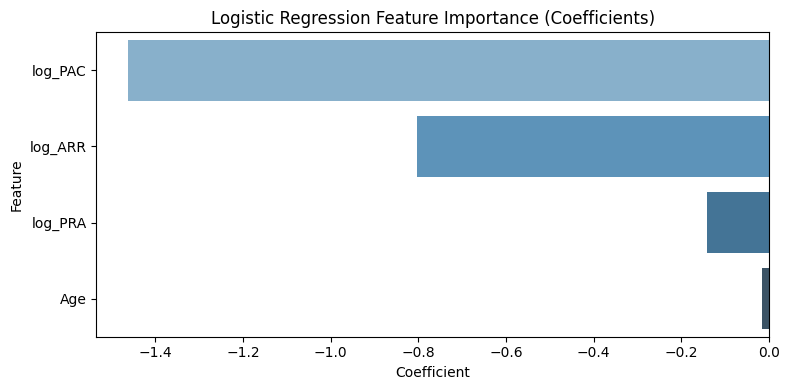

In [42]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=coefficients, 
    x='Coefficient', 
    hue='Feature', 
    y='Feature', 
    palette='Blues_d'
    )
plt.title("Logistic Regression Feature Importance (Coefficients)")
plt.tight_layout()
plt.savefig('../outputs/figures/predictive/LR_histogram.png')
plt.show()

- ARR is clinically associated with APA, but in this cohort linear regression interprets higher values as more aligned with BHA.

**Cross-Validation**

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

# Cross-validation (5-fold)
cv_scores = cross_val_score(LogisticRegression(), X, y, cv=5)

# Train model again on full training set to generate ROC curve
model = LogisticRegression()
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:, 1]

print("Cross-Validation Scores (mean):", cv_scores.mean().round(4),
      "\nCross-Validation Scores (std):", cv_scores.std().round(4))

Cross-Validation Scores (mean): 0.7317 
Cross-Validation Scores (std): 0.0728


**ROC Curve / AUC**

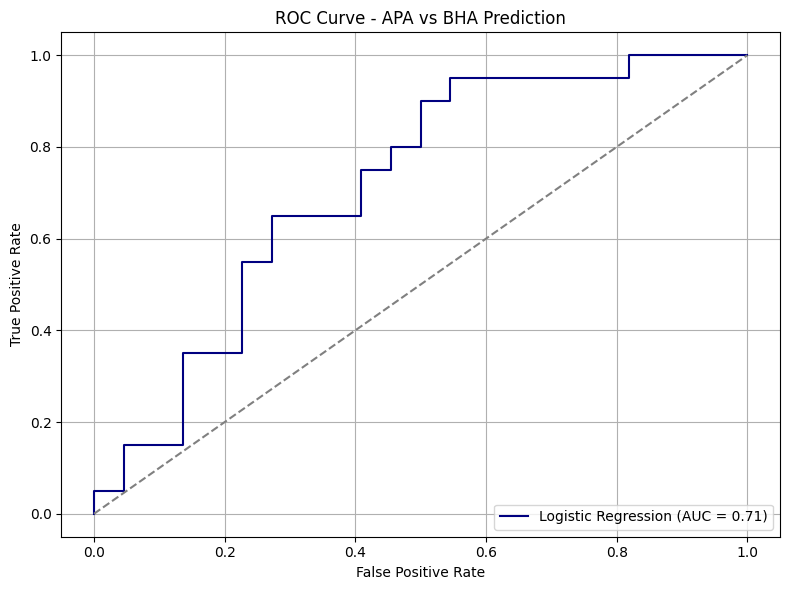

In [44]:
# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(
    fpr,
    tpr, 
    label=f"Logistic Regression (AUC = {roc_auc:.2f})", 
    color='navy'
    )
plt.plot(
    [0, 1], 
    [0, 1], 
    linestyle='--', 
    color='gray'
    )
plt.title("ROC Curve - APA vs BHA Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('../outputs/figures/predictive/LR_ROC.png')
plt.show()

- Logistic regression is a valid first model for APA vs BHA prediction.
- Top predictors: log_PAC, log_ARR